In [6]:
import tensorflow as tf

import cv2
import imghdr
import os

import numpy as np
from matplotlib import pyplot as plt


# For Creating the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

# For Evaluation
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [7]:
data_dir = "data"
image_exts = ["jpeg","jpg","bmp","png"]

In [8]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print(f"Image not in ext list {image_path}")
        os.remove(image_path)
    except Exception as e:
      print(f"issue with image {image_path}")
      os.remove(image_path)

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 360 files belonging to 2 classes.


In [10]:
# scale data
data = data.map(lambda x,y:(x/255.0,y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()


In [11]:
print(batch[0].min())
print(batch[0].max())

0.0
1.0


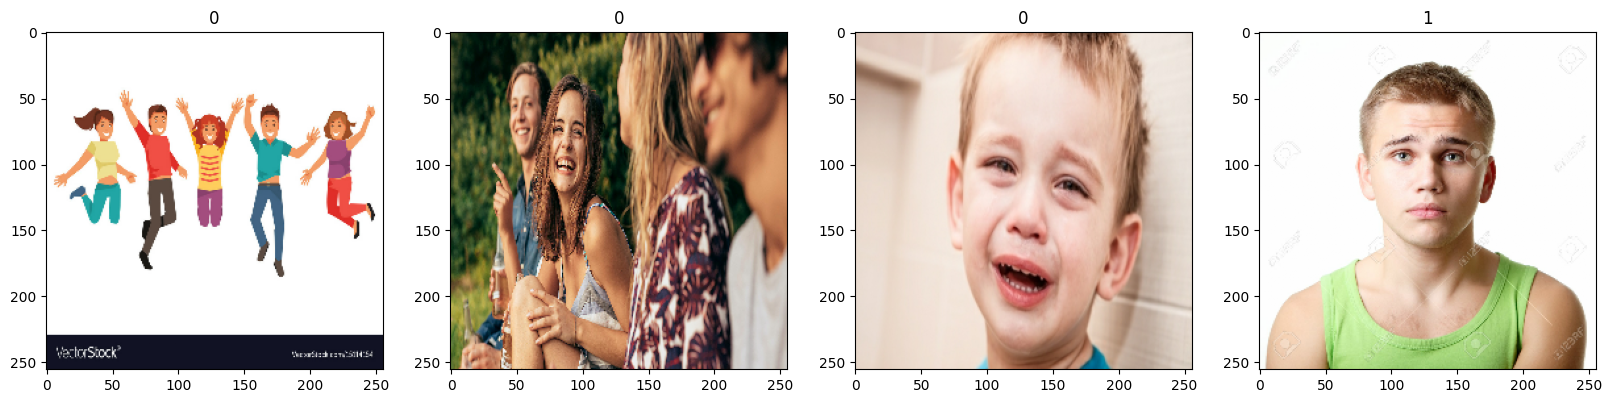

In [12]:
# scale data

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])


In [15]:
# Partition Data
data_len = len(data)
train_size = int(len(data)*.7)
eval_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
print(data_len)
print(train_size,eval_size,test_size)

train_data = data.take(train_size)
eval_data = data.skip(train_size).take(eval_size)
test_data = data.skip(train_size+eval_size).take(test_size)

12
8 3 1


In [25]:
train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:

# Create Model
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation="relu",input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [18]:
# Logging
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training
hist = model.fit(train_data,epochs=20,validation_data=eval_data,callbacks=[tensorboard_callback])

Epoch 1/20


8/8 [==============================] - 10s 742ms/step - loss: 0.8268 - accuracy: 0.5078 - val_loss: 0.6685 - val_accuracy: 0.6042
Epoch 2/20
8/8 [==============================] - 5s 541ms/step - loss: 0.6671 - accuracy: 0.5977 - val_loss: 0.6522 - val_accuracy: 0.5208
Epoch 3/20
8/8 [==============================] - 5s 535ms/step - loss: 0.6392 - accuracy: 0.6484 - val_loss: 0.6113 - val_accuracy: 0.7708
Epoch 4/20
8/8 [==============================] - 5s 540ms/step - loss: 0.5744 - accuracy: 0.6914 - val_loss: 0.5617 - val_accuracy: 0.7396
Epoch 5/20
8/8 [==============================] - 5s 543ms/step - loss: 0.5302 - accuracy: 0.7305 - val_loss: 0.5063 - val_accuracy: 0.7292
Epoch 6/20
8/8 [==============================] - 6s 586ms/step - loss: 0.5053 - accuracy: 0.7500 - val_loss: 0.4326 - val_accuracy: 0.7917
Epoch 7/20
8/8 [==============================] - 6s 609ms/step - loss: 0.4797 - accuracy: 0.7344 - val_loss: 0.4201 - val_accuracy: 0.7708
Epoch 8/20
8/8 [=

# Plot Performace

<function matplotlib.pyplot.show(close=None, block=None)>

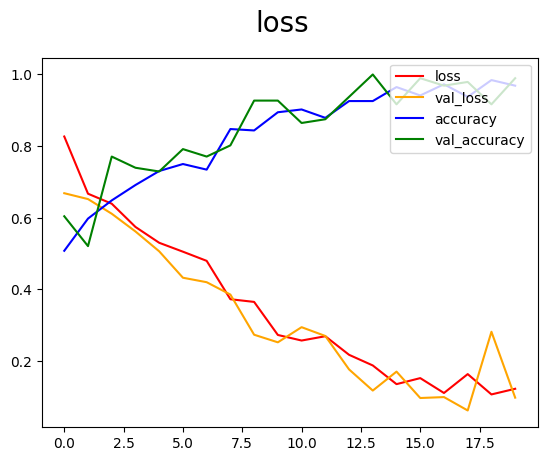

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='red',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
plt.plot(hist.history['accuracy'],color='blue',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='green',label='val_accuracy')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper right')
plt.show

### Evaluate  (using testdata partition)

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test_data.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)




1/1 [==============================] - 0s 50ms/step


In [40]:
print(f"precision: {pre.result().numpy()} || recall: {re.result().numpy()} || accuracy: {acc.result().numpy()}")

precision: 1.0 || recall: 1.0 || accuracy: 1.0


### Evaluate performance (using outside testing data)

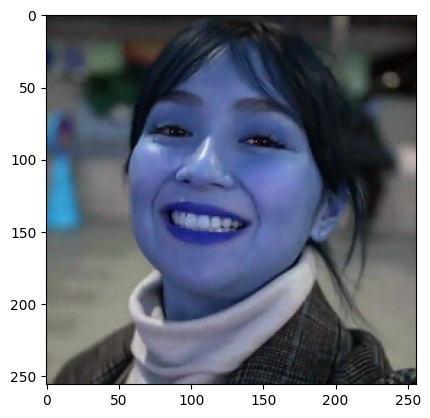

In [43]:
img = cv2.imread(os.path.join("outside-test","test1.jpg"))
resized_img = tf.image.resize(img,(256,256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [45]:
resized_img.shape

TensorShape([256, 256, 3])

In [47]:
np.expand_dims(resized_img/255.0,0).shape

(1, 256, 256, 3)

In [48]:
yhat = model.predict(np.expand_dims(resized_img/255,0))
yhat

1/1 [==============================] - 0s 31ms/step


array([[0.95876753]], dtype=float32)